<a href="https://colab.research.google.com/github/joegamboa/joegamboa/blob/main/gan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D GAN's tutorial  

### This notebook is based on a tutorial from Jason Brownlee called "How to develop a 1D Generative Adversarial Network from scrath in Keras". More details can be found in the link below:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/ 
___

GANs are deep learning arquitecture for training powerful generator models capable to generate new artificial samples that plausibly could have come from an existing distribution of samples.  
GANs are comprised of both generator and discriminator models. The generator generates new samples for the domain and the discriminator classify whether samples are real or generatad by the generator.  
The performance of the discriminator model is used to update both the model weights of the discriminator itself and the generator model. This is a complex model both to understand and to train.  
The main idea of this tutorial is to implement a simple 1D GAN model to give a taste of this type of model. To do this we will follow the steps bellow:  
1. [Select a One-Dimensional Function](#1.)
2. [Define a Discriminator Model](#2.)
3. [Define a Generator Model](#3.)
4. [Training the Generator Model](#4.)
5. [Evaluating the Performance of the GAN](#5.)
6. [Complete Example of Training the GAN ](#6.)

Let's start then. First things first.  


<a name="1."></a>
## 1. Select a One-Dimensional Function.

Let's use a simple function like $y = f(x) = x^2$. This function can be implemented as bellow.

In [ ]:
# simple function
def calculate(x):
  return x*x

To get an insight of this function let's plot it in a small domain, let's say between $x=-0.5$ and $x=0.5$.

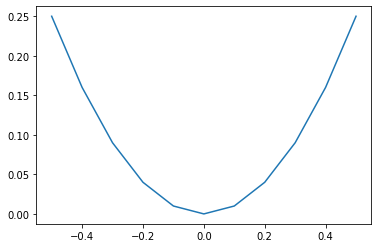

In [ ]:
# plot the function y=f(x)=x²
import matplotlib.pyplot as plt   # library to plot the function
import numpy as np # library to use some lists features

# define inputs inside the domain
inputs = np.linspace(-0.5,0.5,11)

# calculate the outputs
outputs = [calculate(x) for x in inputs]

# plot the results
plt.plot(inputs, outputs)

Now that we have a view of the function we can generate some ramdom values of the function $f(x)=x^2$. This can be done by generating ramdom values between $x=-0.5$ and $x=0.5$ and feeding the function with then. This will be the "real samples". We will that in the following and also plot a scatter of the real samples.
<a name="gen"></a>

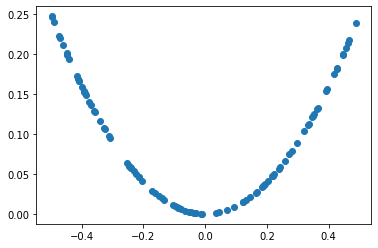

In [ ]:
# generate the real sample
from numpy.random import rand
from numpy import hstack 
from matplotlib import pyplot

def generate_samples(n=100):
  # generates values in the [-0.5,0.5] interval
  X1 = rand(n) - 0.5 # rand generates values in the [0,1] interval
  # generate the outputs f(x)=x²
  X2 = calculate(X1)
  # redefining X1 and X2 as stack arrays
  X1 = X1.reshape(n,1)
  X2 = X2.reshape(n,1)
  return hstack((X1,X2))

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:,0],data[:,1])
pyplot.show()

We can use this procedure as a starting point to generate real samples for our discriminator function. A generator would output a vector with two elements, one input and one output of our one-dimensional function $f(x)$.

<a name="2."></a>
## 2. Define a discriminator model  

One discriminator model most take a sample for our problem and output a classification prediction (real or fake sample). This is a binary classification problem:

- __Inputs__: Sample with real values
- __Outputs__: Binary classification (prediction wheater the sample is real or fake)

To takle this problem we will use a very simple neural network:

- The discriminator model will have one hidden variable layer with 25 nodes
- We will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and an appropriate weight initialization method called He weight initialization.
- The output layer will have one node for the binary classification using a sigmoid activation function.
- The model will minimize the binary cross entropy loss function, and the [Adan version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) will be used because it is very effective.

The define_discriminator() function below defines and returns the discriminator model. the function parameterizes the number of inputs to expect, which defaults to two.

In [1]:
# define the independent discriminator model
def define_discriminator(n_inputs=2):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_imputs))
  model.add(Dense(1, activation='sigmoit'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Now we can use de `define_discriminator()` function to define the discriminator model and summarize it as listed below.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 25)                75        
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


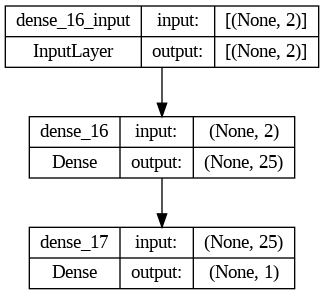

In [12]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# copy of the definition made upward
def define_discriminator(n_inputs=2):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary() # prints the summary table
# plot the model
plot_model(model, to_file='discriminator_plot.png',show_shapes=True, show_layer_names=True) # prints the diagram


We can see by the table that the model expects two inputs and will predict a single output.


We could start training this model now with real examples with a class label ramdonly generated samples with a class label of zero. There is no need to do this, but it will be useful later and will helps to see that the discriminator is just a regular neural network model.
We will first update the [`generate_samples()`](#gen) function from the [last section](#2.) and call it `generate_real_samples()` and have it also return the output class labels for real samples, specifically, an array of 1 values, where class=1 means real.

In [13]:
# generate n real samples with class labels
def generate_real_samples(n):
  # generates inputs in the [-0.5,0.5] interval
  X1 = rand(n) - 0.5 # rand generates values in the [0,1] interval
  # generate the outputs f(x)=x²
  X2 = X1 * X1
  # redefining X1 and X2 as stack arrays
  X1 = X1.reshape(n,1)
  X2 = X2.reshape(n,1)
  X = hstack((X1,X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

Next, we can create a copy of this function to creating fake axamples. In this case, we will generate random values in the range -1 and 1 for both elements of the sample. The output class label will be 0 in this case.

In [14]:
# generate n fake samples with class labels
def generate_fake_samples(n):
  # generates inputs in the [-1,1] interval
  X1 = -1 + rand(n)*2 # rand generates values in the [0,1] interval
  # generates inputs in the [-1,1] interval
  X2 = -1 + rand(n)*2 # rand generates values in the [0,1] interval
  # redefining X1 and X2 as stack arrays
  X1 = X1.reshape(n,1)
  X2 = X2.reshape(n,1)
  X = hstack((X1,X2))
  # generate class labels
  y = zeros((n, 1))
  return X, y

The next step is to create a function to train and evaluate the discriminator model. 

<a name="3."></a>
## 3. Define a generator model  